In [2]:
!pip install -q keras
!pip install -q pandas
!pip install -q numpy
!pip install -q tensorflow
!pip install -U -q PyDrive
!pip install -q torch torchvision

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import glob
import cv2
from tqdm import tqdm

In [0]:
## Parameters

EPOCHS = 50
BS = 8
SIZE = 300 ## Resize factor
TEST_SIZE = 0.2
label_size=4

In [5]:
os.listdir("drive/My Drive/colab_datas/xperience")

['toothbrush',
 'smart-baby-bottle',
 'wake-up-light',
 'shaver',
 'Philips case package.docx',
 'Tech Xperience - Philips case package.pdf',
 'techxperience.zip',
 'TX2020-Philips-case.zip']

In [0]:
# os.chdir("drive/My Drive/colab_datas/xperience")

In [0]:
# !unzip TX2020-Philips-case.zip
# !unzip techxperience.zip

In [8]:
video_paths=glob.glob("drive/My Drive/colab_datas/xperience/*/*.mp4")
for i,video_fp in tqdm(enumerate(video_paths)):
    folder_path=video_fp.split("/")[-2]+"_train"
    if folder_path not in os.listdir():
        os.mkdir(folder_path)
    vidcap = cv2.VideoCapture(video_fp)
    success,image = vidcap.read()
    count = 0
    while success:
        if count%10==0:
            cv2.imwrite(folder_path+"/"+str(i)+"frame%d.jpg" % count, image)   
        success,image = vidcap.read()
        count += 1

16it [07:28, 23.46s/it]


In [0]:

# 16it [09:31, 30.79s/it]

In [10]:
{i:len(os.listdir(i)) for i in glob.glob("./*_train")},

({'./shaver_train': 1617,
  './smart-baby-bottle_train': 1823,
  './toothbrush_train': 2024,
  './wake-up-light_train': 3055},)

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# import os
import copy
import cv2
import glob
plt.ion()   # interactive mode

In [12]:
img_paths=glob.glob("*_train/*")
labels=[i.split("/")[-2].split("_")[0] for i in img_paths]
train_csv=pd.DataFrame()
train_csv["ImageName"]=img_paths
train_csv["labels"]=labels
#train_csv["count"]=[1]*len(train_csv)
#train_csv=pd.pivot_table(train_csv,index="ImageName",values="count",columns="labels").fillna(0).astype(int).reset_index()
train_csv

,ImageName,labels
0,wake-up-light_train/12frame7950.jpg,wake-up-light
1,wake-up-light_train/7frame7600.jpg,wake-up-light
2,wake-up-light_train/12frame6320.jpg,wake-up-light
3,wake-up-light_train/12frame6050.jpg,wake-up-light
4,wake-up-light_train/7frame4300.jpg,wake-up-light
...,...,...
8514,smart-baby-bottle_train/3frame6350.jpg,smart-baby-bottle
8515,smart-baby-bottle_train/3frame6720.jpg,smart-baby-bottle
8516,smart-baby-bottle_train/3frame3430.jpg,smart-baby-bottle
8517,smart-baby-bottle_train/3frame7790.jpg,smart-baby-bottle


# Dataset creation

In [0]:
from PIL import Image
class XperienceDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transforms.Compose(transform)

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        # print(img_name)
        image = cv2.resize(image,(SIZE,SIZE))
        image = Image.fromarray(image)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        image = self.transform(image)
        landmarks=torch.from_numpy(landmarks.astype(int))
        sample = {'image': image, 'landmarks': landmarks}
        return sample["image"],sample["landmarks"]

data_transforms = {
    'train': [
        transforms.RandomRotation(135),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ],
    'val': [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ],
}

# Model Selection

# GoogleNet

In [0]:
from torchvision import models
model = models.googlenet(pretrained=True)
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
# bir epochtan sonra unfreezelencek

In [0]:
# del model.fc
# model=nn.Sequential(model,nn.Linear(2048,1024),nn.ReLU(),nn.Dropout(0.2),nn.Linear(1024,len(labels)),nn.Sigmoid())
model.fc=nn.Sequential(nn.Linear(2048,1024),nn.ReLU(),nn.Dropout(0.2),nn.Linear(1024,label_size),nn.Sigmoid())

In [0]:
# Move to gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to('cuda')
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

# DenseNet

In [0]:
from torchvision import models
model = models.resnet101(pretrained=True)
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
# bir epochtan sonra unfreezelencek

In [0]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
# del model.fc
# model=nn.Sequential(model,nn.Linear(2048,1024),nn.ReLU(),nn.Dropout(0.2),nn.Linear(1024,len(labels)),nn.Sigmoid())
model.fc=nn.Sequential(
    nn.Linear(2048,512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512,label_size),
    nn.Sigmoid())
# model.classifier=nn.Linear(2208,label_size)

In [0]:
# Move to gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to('cuda')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training

In [0]:
val_size=0.2
val_set=np.random.choice(train_csv.ImageName.value_counts().index,int(len(train_csv.ImageName.value_counts().index)*val_size))
val_csv=train_csv.loc[train_csv["ImageName"].isin(val_set)]
val_csv.to_csv("val_csv.csv",index=False)
train_set=[i for i in train_csv.ImageName.value_counts().index if not i in val_set]
trt_csv=train_csv.loc[train_csv["ImageName"].isin(val_set)]
trt_csv.to_csv("train_csv.csv",index=False)

In [0]:
train = XperienceDataset(csv_file="train_csv.csv",root_dir="",transform=data_transforms["train"])
valid = XperienceDataset(csv_file="val_csv.csv",root_dir="",transform=data_transforms["val"])
train_loader = torch.utils.data.DataLoader(train, batch_size=BS, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=BS, shuffle=False)

In [0]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

In [0]:
inputs, classes = next(iter(dataloaders['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
for param in model.parameters():
    param.requires_grad = True

In [0]:
for epoch in range(EPOCHS):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    params_to_update = model.parameters()
    optimizer = optim.Adam(params_to_update, lr=0.01)
    criterion = nn.BCEWithLogitsLoss()
    print('Epoch {}/{}'.format(epoch+1, EPOCHS))
    print('-' * 50)
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0
        if phase=="train":
            for image,label in train_loader:
                image=image.to(device)
                label=label.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(image)
                    label = label.squeeze_()
                    label = label.float()
                    loss = criterion(outputs.squeeze(), label)
                    loss.backward()
                    optimizer.step()
                    # _, preds = torch.max(outputs, 1)
                    preds=torch.round(outputs)
                running_loss += loss.detach().item() * image.size(0)
                running_corrects += torch.sum(preds == label.data) 
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = running_corrects.double()/4 / len(train_loader.dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        else:
            val_loss=0
            for image,label in valid_loader:
                image=image.to(device)
                label=label.to(device)
                outputs = model(image)
                label = label.squeeze_()
                label = label.float()
                loss=criterion(outputs.squeeze(), label)
                val_loss+=loss.detach().item()
            print('{} Loss: {:.4f}'.format(phase, val_loss))
    print()
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
model.load_state_dict(best_model_wts)

# Dataset creation for Keras

In [0]:
train_csv

In [0]:
# df_feature=[]
# df_label=[]
# #label_dict={label: for i,label in enumerate(train_csv.columns[1:])}
# for image_row in tqdm(train_csv.values):
#     img=cv2.imread(image_row[0])
#     img=cv2.resize(img,(SIZE,SIZE))
#     label=image_row[1:]
#     df_feature.append(img)
#     df_label.append(df_label)

# Keras Part

In [14]:
from keras import backend as K
import keras
from keras.layers import Dense,Input,Conv2D,MaxPooling2D,Activation,Flatten,Dropout,Cropping2D,Lambda,GlobalAveragePooling2D,BatchNormalization,AveragePooling2D
from keras.models import Sequential,Model
from keras.optimizers import SGD,rmsprop

## Loss functions   

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def hn_multilabel_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task loss
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

Using TensorFlow backend.


In [0]:
import tensorflow as tf
from tensorflow.python.ops import array_ops

def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=0.75):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

In [0]:
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.metrics import (categorical_accuracy, categorical_crossentropy,
                           top_k_categorical_accuracy)
from keras.optimizers import Adam, SGD


def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
from sklearn.model_selection import train_test_split

train_df,test_df=train_test_split(train_csv,test_size=TEST_SIZE)

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss

#df_feature=np.array(df_feature)

# df_label=np.array(df_label)

#df_feature = preprocess_input(df_feature) ## Rescaling w.r.t. 'imagenet' dataset.

# x_train, x_test, y_train, y_test = train_test_split(df_feature, df_label, test_size=TEST_SIZE)

callbacks = [
            EarlyStopping(patience=15, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
            ]

In [19]:
## Pretraining with imagenet weights

base_model = DenseNet121(include_top=False, weights='imagenet',
                         input_shape=(SIZE, SIZE, 3), classes=15)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(.2)(x)

predictions = Dense(4, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

## Freeze network except last three layers:

for layer in model.layers:  
    layer.trainable = False

for i in range(-3,0):
    model.layers[i].trainable = True

model.compile(optimizer=Adam(lr=1e-4, decay=1e-9), loss=hn_multilabel_loss, metrics=['binary_crossentropy',
              categorical_crossentropy, categorical_accuracy, top_3_accuracy])















29089792/29084464 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Construct the training image generator for data augmentation

aug = ImageDataGenerator(
         rotation_range = 320,
         width_shift_range = 0.45,
         height_shift_range = 0.25,
         shear_range = 0.40,
         zoom_range = 0.30,  
         horizontal_flip = True,
         vertical_flip = True,
         # preprocess_input=True,
         fill_mode ='nearest'
        )
        
aug_val = ImageDataGenerator(rotation_range = 20,
         width_shift_range = 0.15,
         height_shift_range = 0.25,
         shear_range = 0.20,
         zoom_range = 0.20,  
         horizontal_flip = True,
         vertical_flip = True,
         # preprocess_input=True,
         fill_mode ='nearest')

# Train the network


In [21]:
test_df

,ImageName,labels
3484,shaver_train/13frame3010.jpg,shaver
2513,wake-up-light_train/7frame10390.jpg,wake-up-light
3647,shaver_train/14frame20.jpg,shaver
6536,toothbrush_train/0frame4290.jpg,toothbrush
6698,smart-baby-bottle_train/6frame1070.jpg,smart-baby-bottle
...,...,...
5000,toothbrush_train/0frame420.jpg,toothbrush
1694,wake-up-light_train/10frame760.jpg,wake-up-light
5973,toothbrush_train/0frame8200.jpg,toothbrush
4892,toothbrush_train/1frame40.jpg,toothbrush


In [22]:
train_generator=aug.flow_from_dataframe(dataframe=train_df,
                                            directory="./",
                                            x_col="ImageName",
                                            y_col="labels",
                                            subset="training",
                                            batch_size=BS,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(SIZE,SIZE))

valid_generator=aug_val.flow_from_dataframe(dataframe=test_df,
                                            directory="./",
                                            x_col="ImageName",
                                            y_col="labels",
                                            subset="training",
                                            batch_size=BS,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(SIZE,SIZE))

Found 6815 validated image filenames belonging to 4 classes.
Found 1704 validated image filenames belonging to 4 classes.


In [23]:
H = model.fit_generator(train_generator,
                        validation_data = valid_generator , 
                        validation_steps = (len(test_df))// BS,
                        callbacks = callbacks, 
                        steps_per_epoch = len(train_df) // BS,
                        epochs = 5)



Epoch 1/5
851/851 [==============================] - 291s 342ms/step - loss: 0.9132 - binary_crossentropy: 0.2283 - categorical_crossentropy: 0.5123 - categorical_accuracy: 0.8407 - top_3_accuracy: 0.9756 - val_loss: 11.5637 - val_binary_crossentropy: 2.8909 - val_categorical_crossentropy: 5.7513 - val_categorical_accuracy: 0.1743 - val_top_3_accuracy: 0.7952
Epoch 2/5
851/851 [==============================] - 284s 333ms/step - loss: 0.5142 - binary_crossentropy: 0.1285 - categorical_crossentropy: 0.2736 - categorical_accuracy: 0.9246 - top_3_accuracy: 0.9937 - val_loss: 13.6438 - val_binary_crossentropy: 3.4110 - val_categorical_crossentropy: 7.1305 - val_categorical_accuracy: 0.1596 - val_top_3_accuracy: 0.8046
Epoch 3/5
851/851 [==============================] - 284s 333ms/step - loss: 0.4045 - binary_crossentropy: 0.1011 - categorical_crossentropy: 0.2133 - categorical_accuracy: 0.9412 - top_3_accuracy: 0.9944 - val_loss: 14.4373 - val_binary_crossentropy: 3.6093 - val_categoric

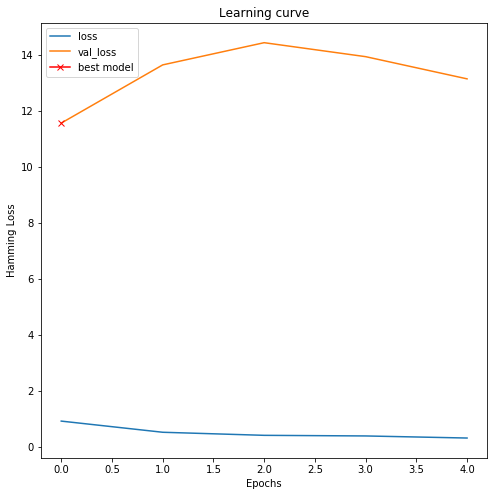

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(H.history["loss"], label="loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot( np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Hamming Loss")
plt.legend()

In [0]:
#out = model.predict(x_test)
#y_pred1 = (out > 0.5) 
#hamming_loss(y_test,y_pred1)

In [0]:
## Save pretraining model.

model.save_weights('model_PRE.h5')
del model

In [0]:
## Training & fine-tuning without imagenet weights

base_model = DenseNet121(include_top=False, weights=None,
                         input_shape=(SIZE, SIZE, 3), classes=15)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(4, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights('model_PRE.h5')

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(lr=1e-5, decay=1e-9), loss=hn_multilabel_loss, metrics=['binary_crossentropy',
              categorical_crossentropy, categorical_accuracy, top_3_accuracy])

In [28]:
# Construct the training image generator for data augmentation

H = model.fit_generator(train_generator,
                        validation_data = valid_generator , 
                        validation_steps = (len(test_df))// BS,
                        callbacks = callbacks, 
                        steps_per_epoch = len(train_df) // BS,
                        epochs = 10)

Epoch 1/10
851/851 [==============================] - 402s 472ms/step - loss: 0.2484 - binary_crossentropy: 0.0621 - categorical_crossentropy: 0.1262 - categorical_accuracy: 0.9646 - top_3_accuracy: 0.9988 - val_loss: 0.0330 - val_binary_crossentropy: 0.0082 - val_categorical_crossentropy: 0.0179 - val_categorical_accuracy: 0.9953 - val_top_3_accuracy: 1.0000
Epoch 2/10
851/851 [==============================] - 375s 441ms/step - loss: 0.1470 - binary_crossentropy: 0.0367 - categorical_crossentropy: 0.0740 - categorical_accuracy: 0.9822 - top_3_accuracy: 0.9996 - val_loss: 0.0127 - val_binary_crossentropy: 0.0032 - val_categorical_crossentropy: 0.0074 - val_categorical_accuracy: 0.9994 - val_top_3_accuracy: 1.0000
Epoch 3/10
851/851 [==============================] - 375s 441ms/step - loss: 0.1103 - binary_crossentropy: 0.0276 - categorical_crossentropy: 0.0559 - categorical_accuracy: 0.9863 - top_3_accuracy: 0.9993 - val_loss: 0.0070 - val_binary_crossentropy: 0.0017 - val_categorical

In [0]:
model.save_weights('model_PRE.h5')

In [0]:
    import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(H.history["loss"], label="loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot( np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Hamming Loss")
plt.legend()

In [33]:
!docker images

/bin/bash: docker: command not found


In [0]:
img=cv2.imread("./drive/My Drive/colab_datas/xperience/toothbrush/image4.jpg")
img=cv2.resize(img,(SIZE,SIZE))

In [0]:
output_dict={train_generator.class_indices[label]:label for label in train_generator.class_indices.keys()}

In [0]:
import pickle
output_dict={train_generator.class_indices[label]:label for label in train_generator.class_indices.keys()}
with open("output_dict.pkl","wb") as file:
    pickle.dump(output_dict,file)

'toothbrush'

In [0]:
    test_images=glob.glob("./drive/My Drive/colab_datas/xperience/*/*.jpg")

In [0]:
test_images

['./drive/My Drive/colab_datas/xperience/toothbrush/image1.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image15.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image6.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image14.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image5.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image10.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image8.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image4.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image7.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image12.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image3.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image11.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image9.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image2.jpg',
 './drive/My Drive/colab_datas/xperience/toothbrush/image13.jpg',
 './drive/My Drive/

In [0]:
    wrong_pred=0
    for img_path in test_images:
        img=cv2.imread(img_path)
        img=cv2.resize(img,(SIZE,SIZE))
        pred=model.predict(np.array([img]))
        label_indice=np.argmax(pred)
        print("Real label: {}, predicted output: {}".format(img_path.split("/")[-2],output_dict[label_indice]))
        if img_path.split("/")[-2] != output_dict[label_indice]:
            wrong_pred+=1
    wrong_pred/len(test_images)

Real label: toothbrush, predicted output: wake-up-light
Real label: toothbrush, predicted output: wake-up-light
Real label: toothbrush, predicted output: toothbrush
Real label: toothbrush, predicted output: wake-up-light
Real label: toothbrush, predicted output: toothbrush
Real label: toothbrush, predicted output: toothbrush
Real label: toothbrush, predicted output: toothbrush
Real label: toothbrush, predicted output: toothbrush
Real label: toothbrush, predicted output: toothbrush
Real label: toothbrush, predicted output: toothbrush
Real label: toothbrush, predicted output: wake-up-light
Real label: toothbrush, predicted output: toothbrush
Real label: toothbrush, predicted output: toothbrush
Real label: toothbrush, predicted output: toothbrush
Real label: toothbrush, predicted output: toothbrush
Real label: toothbrush, predicted output: toothbrush
Real label: smart-baby-bottle, predicted output: smart-baby-bottle
Real label: smart-baby-bottle, predicted output: wake-up-light
Real label

0.328125